This notebook uses Grounding DINO to predict objects in an image using a the Zero-Shot Object Detection task.
https://huggingface.co/docs/transformers/main/en/model_doc/grounding-dino

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from typing import List

import cv2
from matplotlib import pyplot as plt

In [6]:
def predict_objects(image: Image, text: str) -> List:
    """
    Predicts objects in an image given a prompt using a zero-shot object detection model.

    Args:
        image (PIL.Image.Image): The input image.
        text (str): The prompt to ground object detection.

    Returns:
        List: A list of predicted objects with their corresponding bounding boxes and scores.
    """
    
    # Define the model ID and device for inference
    model_id = "IDEA-Research/grounding-dino-base"
    device = torch.device("mps")  # Using Metal Performance Shaders (MPS) on Apple devices

    # Initialize the processor for input preprocessing
    processor = AutoProcessor.from_pretrained(model_id)

    # Load the pre-trained model for zero-shot object detection
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

    # Preprocess the input image and text using the processor
    inputs = processor(images=image, text=text, return_tensors="pt").to(device)

    # Perform inference on the model without tracking gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the output using the processor's method
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.5,  # Threshold for bounding box detection
        text_threshold=0.1,  # Threshold for text-based grounding
        target_sizes=[image.size[::-1]]  # Input image size in pixels (width, height)
    )

    return results

In [3]:
def draw_bounding_boxes(image_path: str, results: List[dict]):
    """
    Draws bounding boxes on the original image based on predicted objects.

    Args:
        image_path (str): The path to the input image.
        results (List[dict]): The list of predicted objects with their bounding boxes and labels.
                              Each dictionary in the list contains 'scores', 'labels', and 'boxes'.
    """
    
    # Open the image using OpenCV
    image = cv2.imread(image_path)

    # Iterate through each object and draw its bounding box
    for box, label, score in zip(results[0]['boxes'], results[0]['labels'], results[0]['scores']):
        # Extract the coordinates of the bounding box
        x1, y1, x2, y2 = box.tolist()
        
        # Draw the bounding box on the image
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
        # Label the bounding box with its class label and score
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        label_text = f"{label} ({score:.2f})"
        cv2.putText(image, label_text, (int(x1), int(y1)-5), font, 1, (0, 0, 255), 2)

    # Display the output image with bounding boxes
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()


[{'scores': tensor([], device='mps:0'), 'labels': [], 'boxes': tensor([], device='mps:0', size=(0, 4))}]


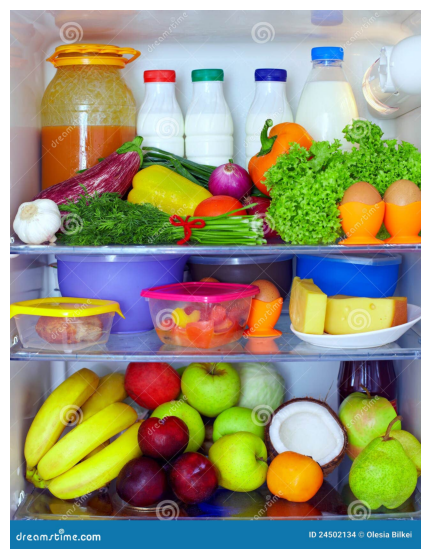

In [8]:
image_path = "../data/ddgs/image_1.jpg"
image = Image.open(image_path)
text = "lettuce. banana. coconut. orange. bell pepper. apple"

results = predict_objects(image, text)
print(results)

draw_bounding_boxes(image_path, results)